# Importing Required Libraries

In [5]:
pip install pycountry

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import pandas as pd
import numpy as np
import warnings
import pycountry
warnings.filterwarnings('ignore')

# DATA CLEANING

## FIPS DATASET CLEANING

In [8]:
df = pd.read_csv('FIPS data.csv')

df1 = df

# Select rows where Extra3 is not null
not_null_extra3 = df1['Extra 3'].notna()
# Update Names column with non-null values from Extra3
df1.loc[not_null_extra3, 'Names'] = df1.loc[not_null_extra3, 'Extra 3']
# Set Extra1, Extra2, and Extra3 to None for all rows
df1.loc[not_null_extra3, ['Extra 1', 'Extra 2', 'Extra 3']] = None

# Selecting all with provincie
provincie = df1['Extra 1'] == 'provincie'
# Update Extra 1 column with from Extra2
df1.loc[provincie, 'Extra 1'] = df1.loc[provincie, 'Extra 2']
# Set Extra2 to None for entire column ca we dont have any important info
df1.loc[:,['Extra 2', 'Extra 3']] = None

# Select rows where Extra3 is not null
not_null_extra1 = df1['Extra 1'].notna()
# Update Names column with non-null values from Extra3
df1.loc[not_null_extra1, 'Names'] = df1.loc[not_null_extra1, 'Extra 1']
# Set Extra1, Extra2, and Extra3 to None for all rows
df1.loc[not_null_extra1, ['Extra 1']] = None

df2 = df1.drop(columns=['ISO ALPHA 3','ISO NUMERIC','Extra 1','Extra 2','Extra 3'],axis=1)
df3 = df2

df3['FIPS_COUNTRY'] = df3['FIPS'].apply(lambda x: x[0:2])
df3['FIPS_STATE CODE'] = df3['FIPS'].apply(lambda x: x[2:4])

- we need only a few amount of columns so treating all the extra columns starting from right most extra 3
- As you can see Extra 3 has all states names 
- Canton/Kanton means It is a German word that means "district" or "administrative division." It is used in a number of countries, including Switzerland, France, and Belgium
- so just making  extra 1,2,3 nulls and replacing the names with extra 3

- from 390 to 401 the province name is almost same province/provincie in both names and extra 1 columns apart from that every thing is ok
- so replacing everthing in extra 1 as provincie with extra 2 and making nulls respectively

In [9]:
df3.drop(columns=['FIPS'],axis=1,inplace=True)

# Selecting countries only
state_only = df3['FIPS_STATE CODE'] == '00'
df4 = df3.loc[state_only,['COUNTRY / STATES','Names','FIPS_COUNTRY','FIPS_STATE CODE']]

# converting country names from uppercase to title
df4['Names'] = df4['Names'].apply(lambda x: x.title())

In [10]:
# some of the countries are being misrespresented or not matching with the data 
# instead of dropping valuable data we did this thing manually for few of the countries
def get_country_alpha3(country_name):
    try:
        country = pycountry.countries.get(name=country_name)
        if country_name == "Romania":
            return "ROM"
        elif country_name == "Russia":
            return "RUS"
        elif country_name == "Czech Republic":
            return "CZE"
        elif country_name == "Latvia":
            return "LVA"
        elif country_name == "United Kingdom":
            return "GBR"
        elif country_name == "Iran":
            return "IRN"
        elif country_name == "Bahamas, The":
            return "BAH"
        elif country_name == "Moldova":
            return "MDA"
        elif country_name == "Macedonia":
            return "MKD"
        elif country_name == "Tanzania":
            return "TAN"
        elif country_name == "Laos":
            return "LAO"
        elif country_name == "Burma":
            return "MMR"
        elif country_name == "Ivory Coast":
            return "CIV"
        elif country_name == "Sri Lanka":
            return "LKA"
        return country.alpha_3
    except AttributeError:
        return None
df4['code'] = df4['Names'].apply(get_country_alpha3)

In [11]:
# creating a dictionary so that we can map on the below data
k = dict(zip(df4['FIPS_COUNTRY'],df4['code']))

# Now considering the states of all countries
state_only = df3['FIPS_STATE CODE'] != '00'
df5 = df3.loc[state_only,['Names','FIPS_COUNTRY','FIPS_STATE CODE']]
df5['alpha_3'] = df5['FIPS_COUNTRY'].map(k)

# Considering only required columns and renaming them so that merging will be easy with other part of dataset
df6 = df5[['Names','FIPS_STATE CODE','alpha_3']]
df6.rename(columns={'Names':'state_names','FIPS_STATE CODE':'state_code','alpha_3':'country_code'},inplace=True)

In [12]:
# Resetting the index and dropping the duplicates
df7 = df6.reset_index()
df7.drop(columns=['index'],axis=1,inplace=True)
dedup_df = df7.drop_duplicates()

## COMPANIES DATASET CLEANING

In [13]:
mdf = pd.read_csv('companies.csv')

In [14]:
# Dropping the permalink and url cz they are not being used and we tried web scrapping to
mdf1 = mdf.drop(columns=['permalink','homepage_url'])
# In name columns some names doesn't make sense cz of special characters so we are treating them
mdf1['name'] = mdf1['name'].replace({'[^A-Za-z0-9\s\-\.\,]+': ' '}, regex=True)
# there are few nulls in both of the below columns and we imputed them using the appropriate dates by shuffling the three columns
mdf1['founded_at'] = mdf1['founded_at'].fillna(mdf1['first_funding_at'])
mdf1['first_funding_at'] = mdf1['founded_at'].fillna(mdf1['founded_at'])

In [15]:
mdf1.shape
# checking shape now cz we are gonna delete the rows that are having nulls in all the below columns that are being mentioned

(66368, 12)

In [16]:
mdf2 = mdf1.dropna(subset=['country_code','state_code', 'region', 'city'])

In [17]:
# In our state code column usa and canada have ISO alpha 2 coding instead of the FIPS numbering inorder to genearlize the data
# we have initiated a dict that have ISO alpha 2 key and FIPS code as value
# and we map it on the state code
state_fips = {'AL': '01', 'AK': '02', 'AZ': '04', 'AR': '05', 'CA': '06',
              'CO': '08', 'CT': '09', 'DE': '10', 'FL': '12', 'GA': '13',
              'HI': '15', 'ID': '16', 'IL': '17', 'IN': '18', 'IA': '19',
              'KS': '20', 'KY': '21', 'LA': '22', 'ME': '23', 'MD': '24',
              'MA': '25', 'MI': '26', 'MN': '27', 'MS': '28', 'MO': '29',
              'MT': '30', 'NE': '31', 'NV': '32', 'NH': '33', 'NJ': '34',
              'NM': '35', 'NY': '36', 'NC': '37', 'ND': '38', 'OH': '39',
              'OK': '40', 'OR': '41', 'PA': '42', 'RI': '44', 'SC': '45',
              'SD': '46', 'TN': '47', 'TX': '48', 'UT': '49', 'VT': '50',
              'VA': '51', 'WA': '53', 'DC':'53','WV': '54', 'WI': '55', 'WY': '56',
              'AB': '01', 'BC': '02', 'MB': '03', 'NB': '04', 'NL': '05',
              'NT': '06', 'NS': '07', 'NU': '08', 'ON': '09', 'PE': '10',
              'QC': '11', 'SK': '12', 'YT': '13'}
mdf2['state_code'] = mdf2.apply(lambda x: state_fips.get(x['state_code']) if (x['country_code'] in ['USA','CAN']) else x['state_code'],axis=1)

In [18]:
# there are some nulls in category so we filled it with other
mdf2['category_list'] = mdf2['category_list'].fillna('Other')
# the categorys first name before | is the main name so only considering that
mdf2['category_list'] = mdf2['category_list'].apply(lambda s: s.split('|')[0] if '|' in s else s)

In [19]:
# the state code should be in the format of 01,02,10,11,... but 
# for a few of them it is in the format of 1,2,3,4 as single digits
# so adding a zero before those numbers inorder to get them into a generalized form
mdf2['state_code'] = mdf2['state_code'].apply( lambda x : '0'+x if len(x)==1 else x)

In [20]:
# checking for the amount of nulls percentage 
mdf2.isna().mean().round(4)*100

name                 0.00
category_list        0.00
funding_total_usd    0.00
status               0.00
country_code         0.00
state_code           0.00
region               0.00
city                 0.00
funding_rounds       0.00
founded_at           0.01
first_funding_at     0.01
last_funding_at      0.00
dtype: float64

In [21]:
# checking the shape of df before merging
mdf2.shape

(57524, 12)

## Merging Companies and FIPS data

In [22]:
# merging the data cz we wanted a state name for proper analysis and we did that above
# so using an inner join and merging it
merged_df = pd.merge(mdf2,dedup_df, on=['country_code','state_code'], how='inner')
merged_df.shape

(57679, 13)

In [23]:
# dropping the state code column as it is not required
merged_df.drop(columns=['state_code'],axis=1,inplace=True)

In [24]:
reindexing_columns = ['name', 'category_list', 'funding_total_usd', 
                      'funding_rounds', 'status', 'country_code', 'state_names',
                      'region', 'city', 'founded_at', 'first_funding_at',
                      'last_funding_at']
merged_df = merged_df.reindex(columns=reindexing_columns)

In [25]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57679 entries, 0 to 57678
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               57678 non-null  object
 1   category_list      57679 non-null  object
 2   funding_total_usd  57679 non-null  object
 3   funding_rounds     57679 non-null  int64 
 4   status             57679 non-null  object
 5   country_code       57679 non-null  object
 6   state_names        57679 non-null  object
 7   region             57679 non-null  object
 8   city               57679 non-null  object
 9   founded_at         57676 non-null  object
 10  first_funding_at   57676 non-null  object
 11  last_funding_at    57679 non-null  object
dtypes: int64(1), object(11)
memory usage: 5.7+ MB


## Handling inconsistencies in funds col

In [26]:
merged_df.isnull().sum()

name                 1
category_list        0
funding_total_usd    0
funding_rounds       0
status               0
country_code         0
state_names          0
region               0
city                 0
founded_at           3
first_funding_at     3
last_funding_at      0
dtype: int64

In [27]:
merged_df.dropna(subset=['name'], inplace=True)
merged_df.isnull().sum()

name                 0
category_list        0
funding_total_usd    0
funding_rounds       0
status               0
country_code         0
state_names          0
region               0
city                 0
founded_at           3
first_funding_at     3
last_funding_at      0
dtype: int64

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [29]:
# Convert the "amount" column from object to float
merged_df["funding_total_usd"] = merged_df["funding_total_usd"].replace('-', '0')

# Convert the "funds_raised" column from object to int
# merged_df["funding_total_usd"] = merged_df["funding_total_usd"].astype(int)
merged_df["funding_total_usd"] = merged_df["funding_total_usd"].astype(float)
merged_df["funding_total_usd"] = merged_df["funding_total_usd"].round(3)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57678 entries, 0 to 57678
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               57678 non-null  object 
 1   category_list      57678 non-null  object 
 2   funding_total_usd  57678 non-null  float64
 3   funding_rounds     57678 non-null  int64  
 4   status             57678 non-null  object 
 5   country_code       57678 non-null  object 
 6   state_names        57678 non-null  object 
 7   region             57678 non-null  object 
 8   city               57678 non-null  object 
 9   founded_at         57675 non-null  object 
 10  first_funding_at   57675 non-null  object 
 11  last_funding_at    57678 non-null  object 
dtypes: float64(1), int64(1), object(10)
memory usage: 5.7+ MB


# EDA

## Question 1 : Distribution of funding raised over a time frame.

To see the distribution of funds raised over the years:
1. We intially visualed the funds column to see if the data is normally distributed
2. Extracted the year from last_funding_year column and converted its data type from obj to int
3. FIltered out data and only considered last funding year till 2023(current year)
4. Grouped by the data with respect to last funding year and then found the sum of funds raised within that year
5. Plotted the graph for last funding year and respective funds raised within that year

In [30]:
merged_df['funding_total_usd']=pd.to_numeric(merged_df['funding_total_usd'],errors='coerce')
# group by category_list and country_code, and impute missing values using the median value for each group
merged_df['funding_total_usd']=merged_df.groupby(['category_list','country_code'])['funding_total_usd'].transform(lambda x:x.fillna(x.mean()))

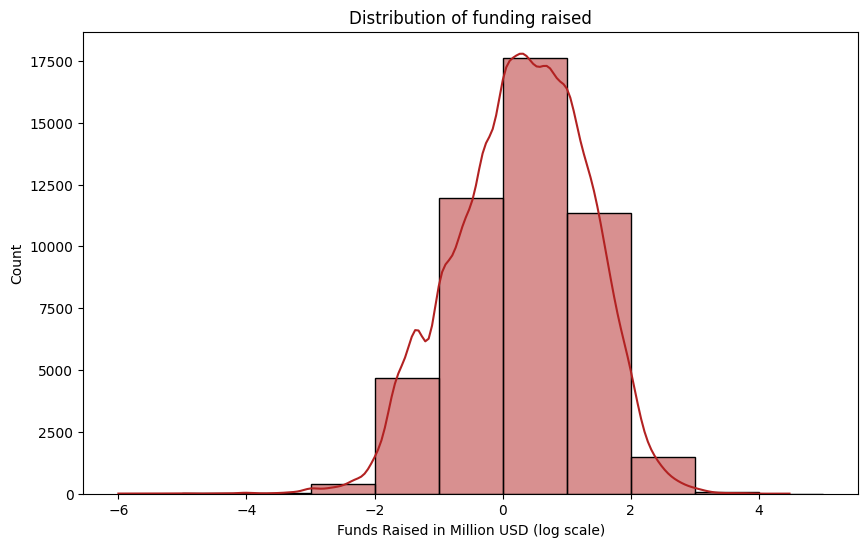

In [31]:
# Create histogram using Seaborn
# Filter out negative or zero values
plt.figure(figsize=(10, 6))
# Create histogram using Seaborn with log scale on x-axis
sns.histplot(data=merged_df, x=np.log10(merged_df['funding_total_usd']/1000000), binwidth=1, color="firebrick",kde=True)
plt.xlabel('Funds Raised in Million USD (log scale)')
plt.title('Distribution of funding raised')
# Set x-axis scale to log
#plt.xscale('log')
plt.grid(False)
plt.show()

In [32]:
merged_df['last_funding_at_year'] = merged_df['last_funding_at'].str.split('-').str[0]
merged_df['last_funding_at_year'] = merged_df['last_funding_at_year'].astype(int)
merged_df = merged_df[merged_df["last_funding_at_year"] <= 2023]
mdf2_grouped = merged_df.groupby('last_funding_at_year')
funding_by_year = mdf2_grouped['funding_total_usd'].sum().reset_index(name='funding_sum_year') 


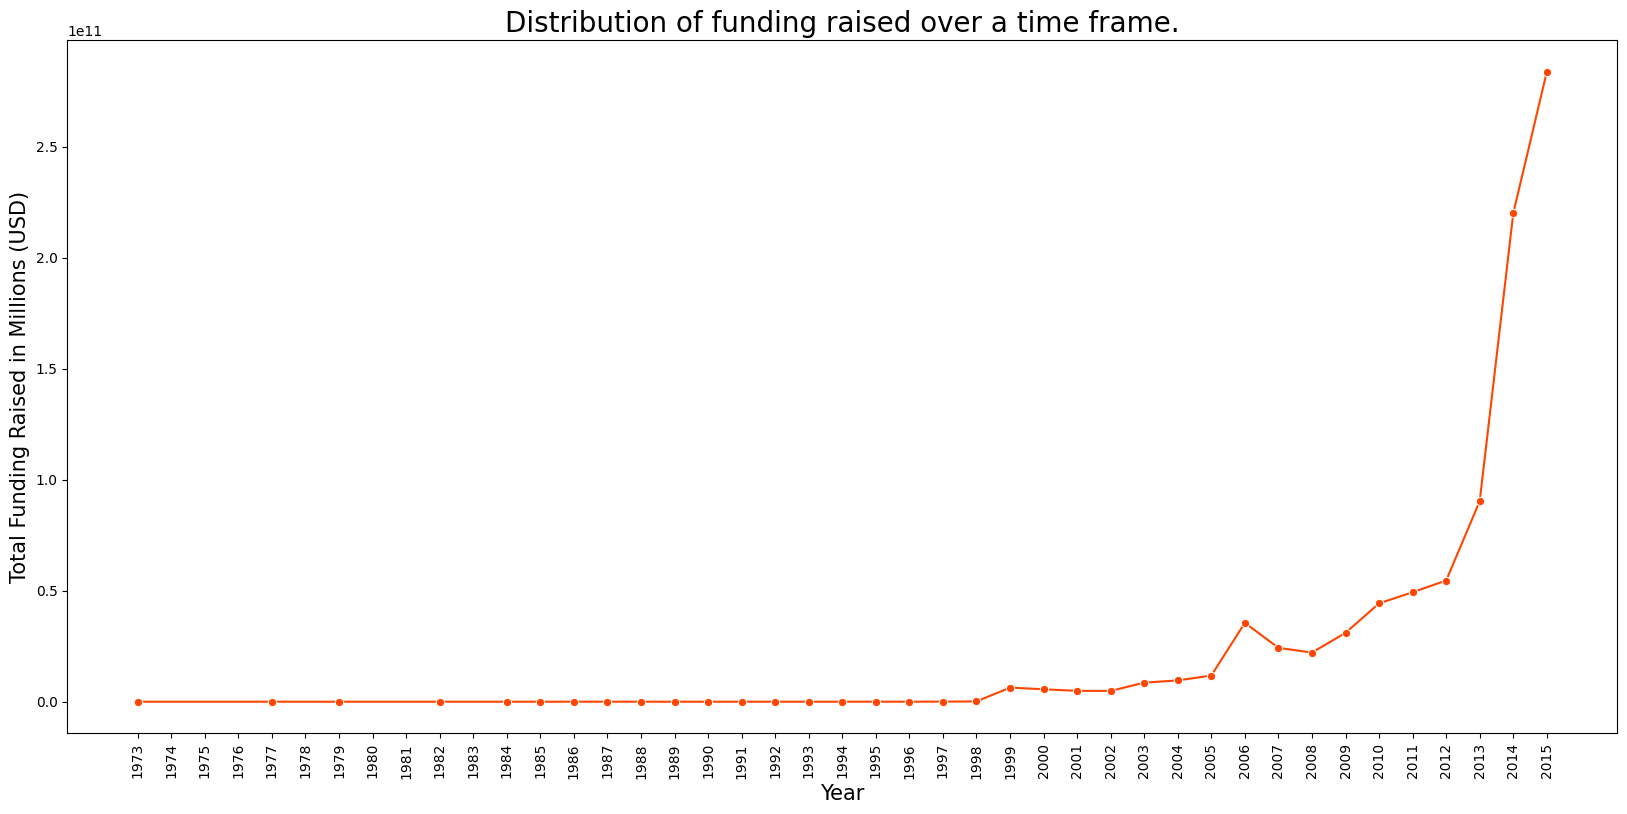

In [33]:
plt.figure(figsize=(20, 9))
years = np.arange(funding_by_year["last_funding_at_year"].min(),funding_by_year["last_funding_at_year"].max()+1)
sns.lineplot(data=funding_by_year, x='last_funding_at_year', y='funding_sum_year', color="orangered",marker='o')
plt.xticks(years,rotation=90)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Total Funding Raised in Millions (USD)', fontsize=15)
plt.title('Distribution of funding raised over a time frame.', fontsize=20)
plt.grid(False)
plt.show()

## Question 2 : Companies in focus - Companies that have raised the most funding.

To see the companies that raised most funding:
1. We sorted the funding column in descending order and considered the top 20 records
2. Plotted the bar graph for the top 20 company names with respect to their funding

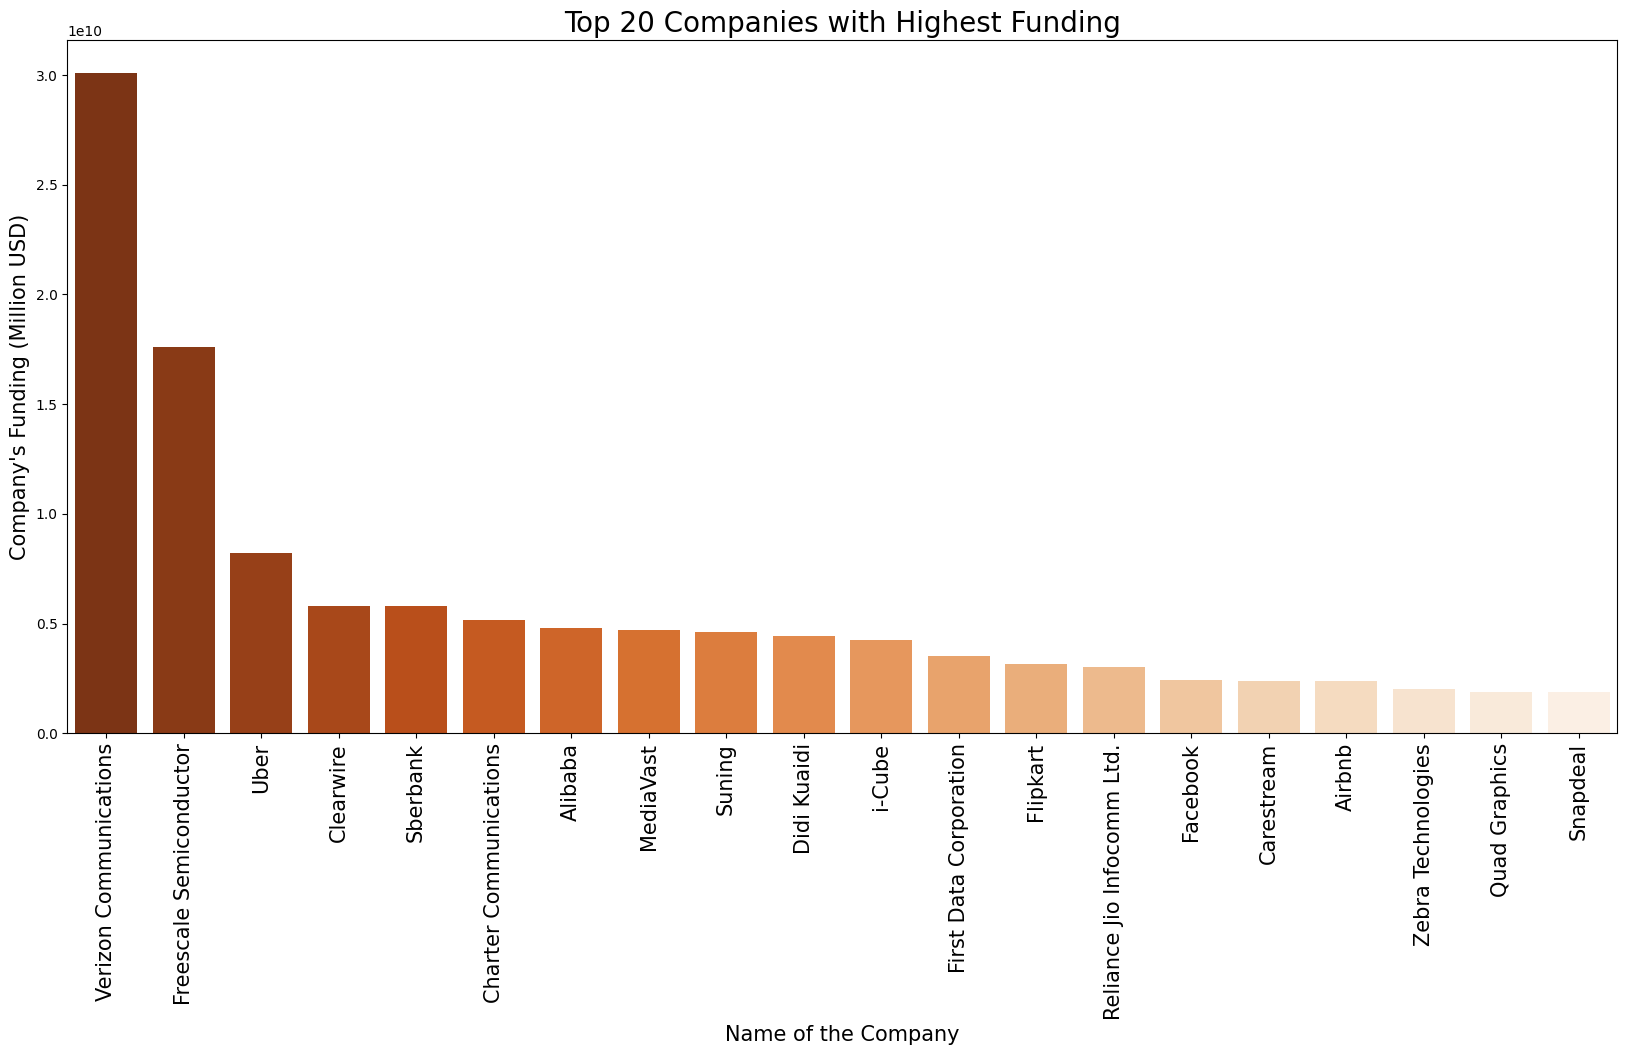

In [34]:
merged_df = merged_df.sort_values(by='funding_total_usd', ascending=False)

# Select top 20 companies
mdf2_top20 = merged_df.head(20)

# Create bar plot using Seaborn
plt.figure(figsize=(20,9))
sns.barplot(x='name', y='funding_total_usd', data=mdf2_top20, palette='Oranges_r')
plt.xlabel('Name of the Company', fontsize=15)
plt.ylabel("Company's Funding (Million USD)", fontsize=15)
plt.title('Top 20 Companies with Highest Funding' , fontsize=20)
plt.xticks(rotation=90,fontsize=15)
plt.grid(False)
plt.show()

## Question 3: Establishing a relationship between the industries and the feasibility of a business based on the location.

To establish a relationship between the industries and the feasibility of the business based on lacation:
1. We intially grouped the data with respect to the category of the company and then sorted the records according to funding and considered top 20 records.
2. Then plotted the bar plot to see the categories of the start up's
3. We then considered the records of top 5 categories and converted it to a list and then fitered the dataset to include only top 5 categories.
4. We then grouped by the data with respect to the category list and city and simultaneously found the sum of funding received.
5. Then retrieved the data of top 3 cities for each of the 5 categories.
6. Looped through each and every category plotted a bar plot.

In [35]:
category_group = merged_df.groupby('category_list') 
funding_by_category = category_group['funding_total_usd'].sum().reset_index(name='funding_sum') 
funding_by_category = funding_by_category.sort_values('funding_sum', ascending=False) 
funding_by_category_top20 = funding_by_category.head(20)

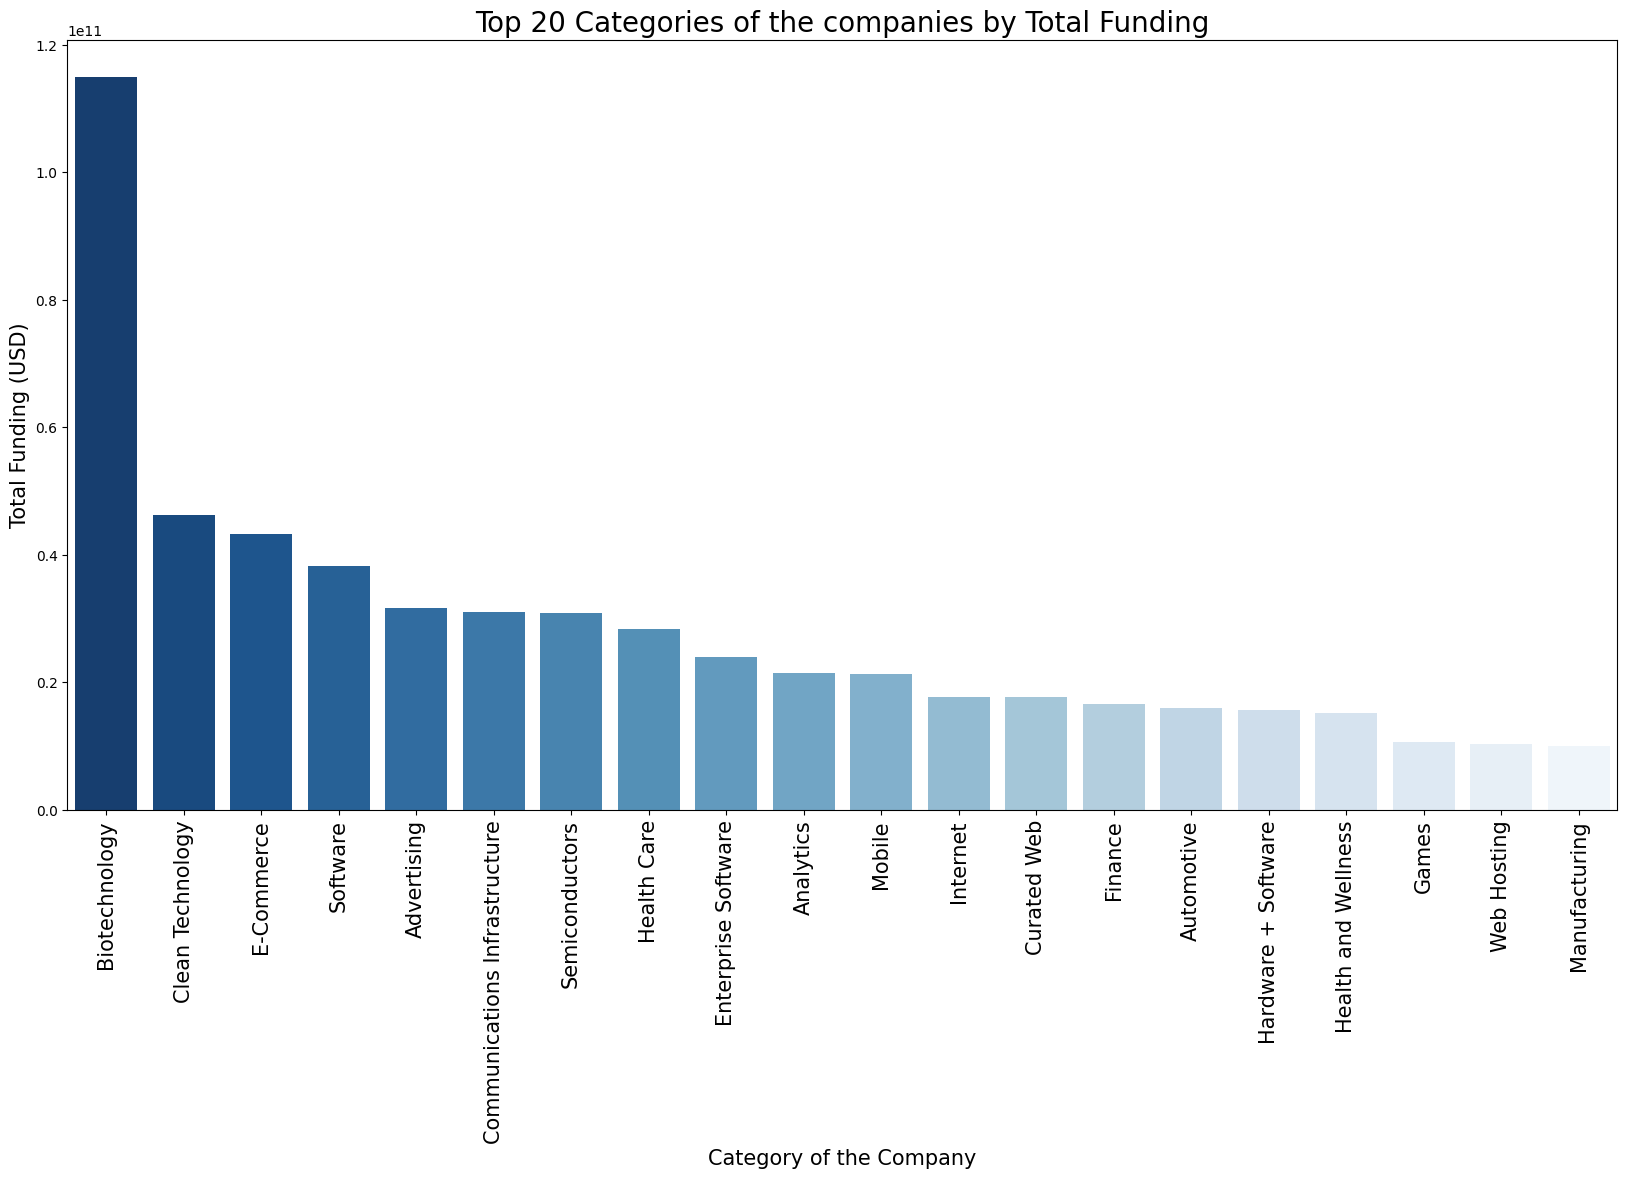

In [36]:
# Create bar plot using Seaborn
# Create a bar plot using Seaborn
plt.figure(figsize=(20, 10))
sns.barplot(data=funding_by_category_top20, x='category_list', y='funding_sum', palette='Blues_r')
plt.xticks(rotation=90,fontsize=15)
plt.xlabel('Category of the Company',fontsize=15)
plt.ylabel('Total Funding (USD)',fontsize=15)
plt.title('Top 20 Categories of the companies by Total Funding',fontsize=20)
plt.grid(False)
plt.show()

In [37]:
funding_by_category_top5 = funding_by_category.head(5)
funding_by_category_top5

,category_list,funding_sum
67,Biotechnology,1.149989e+11
110,Clean Technology,4.628458e+10
217,E-Commerce,4.333376e+10
641,Software,3.826830e+10
9,Advertising,3.172172e+10


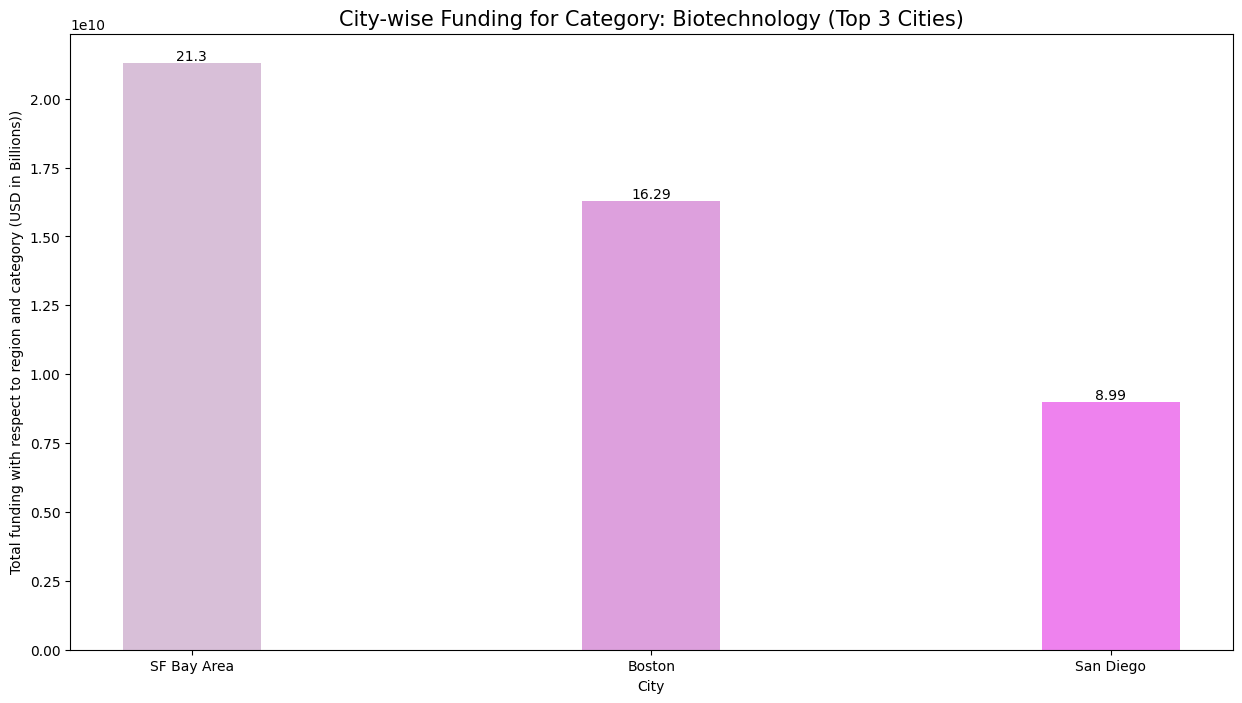

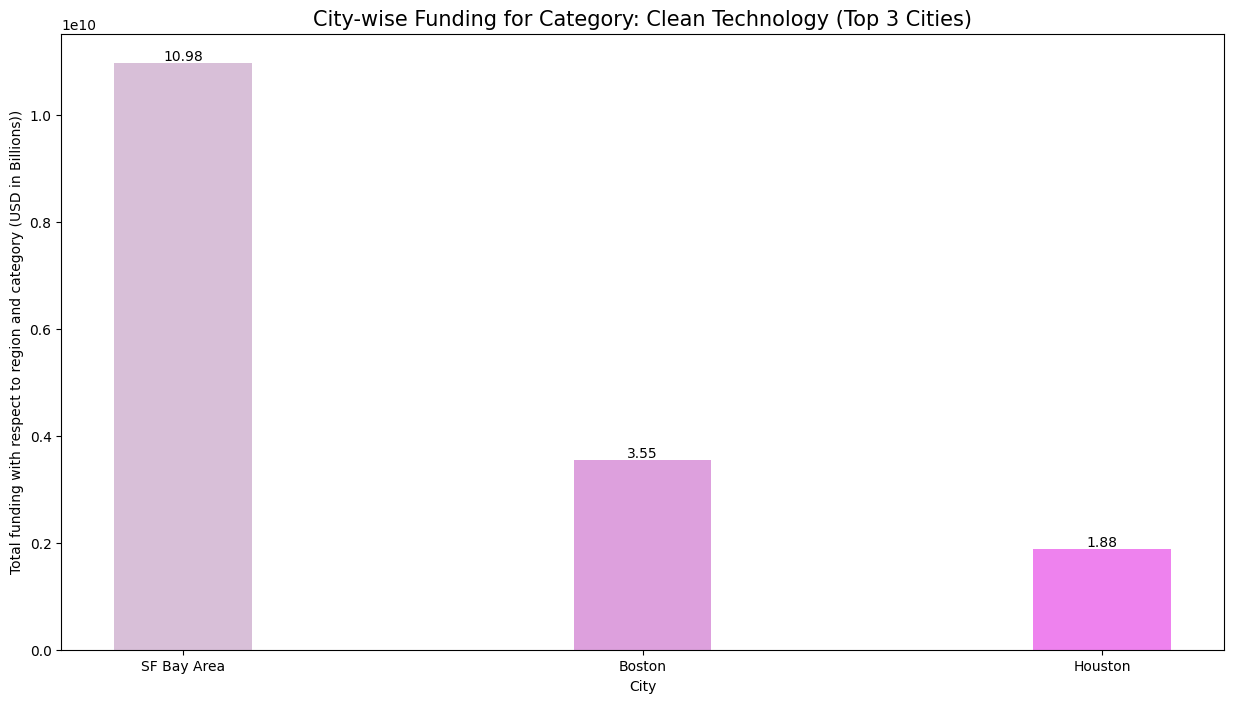

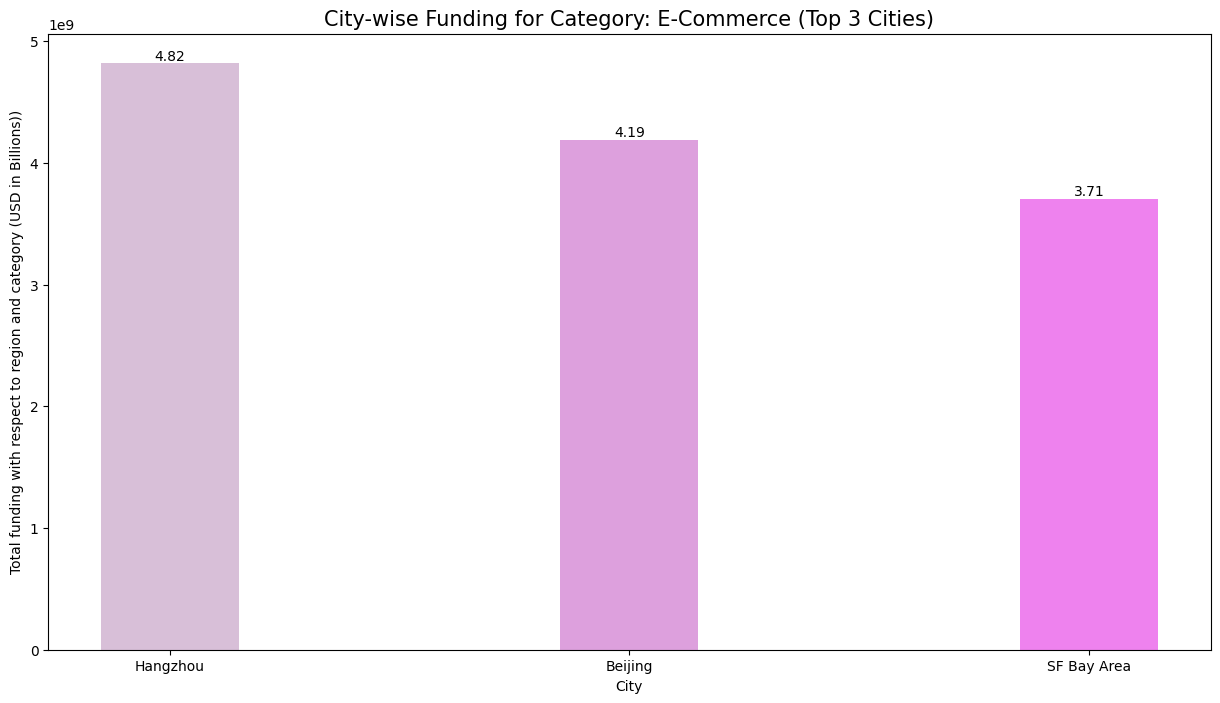

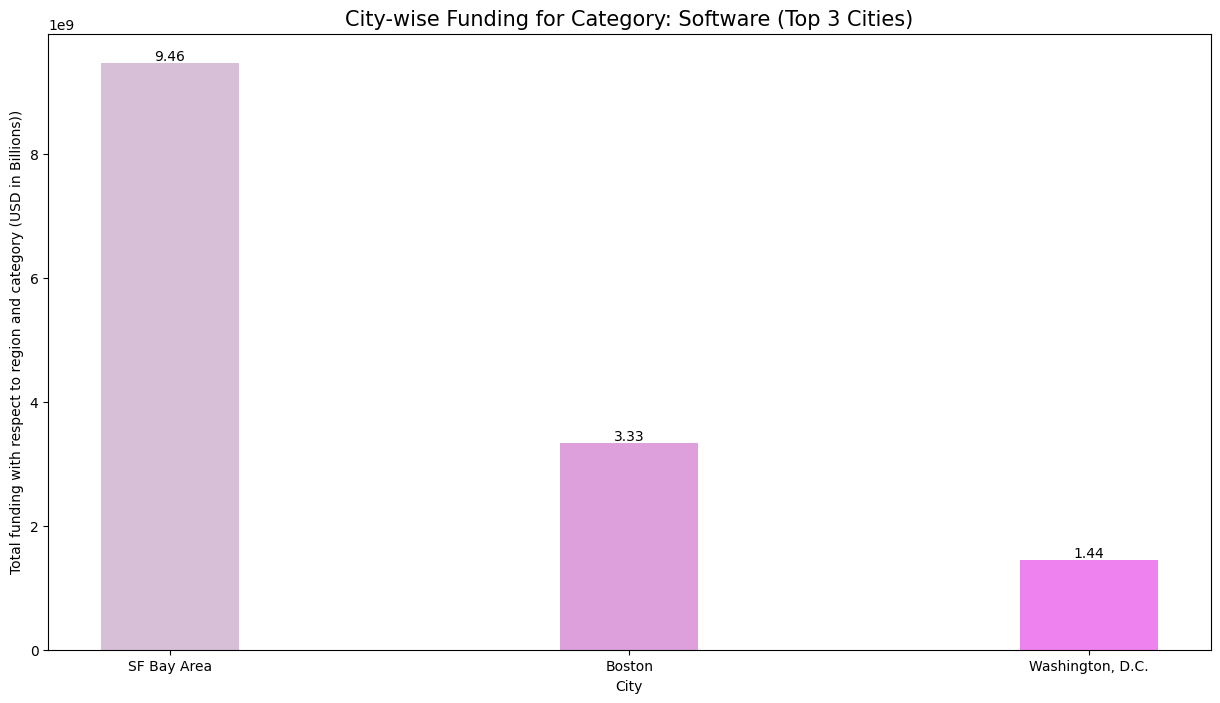

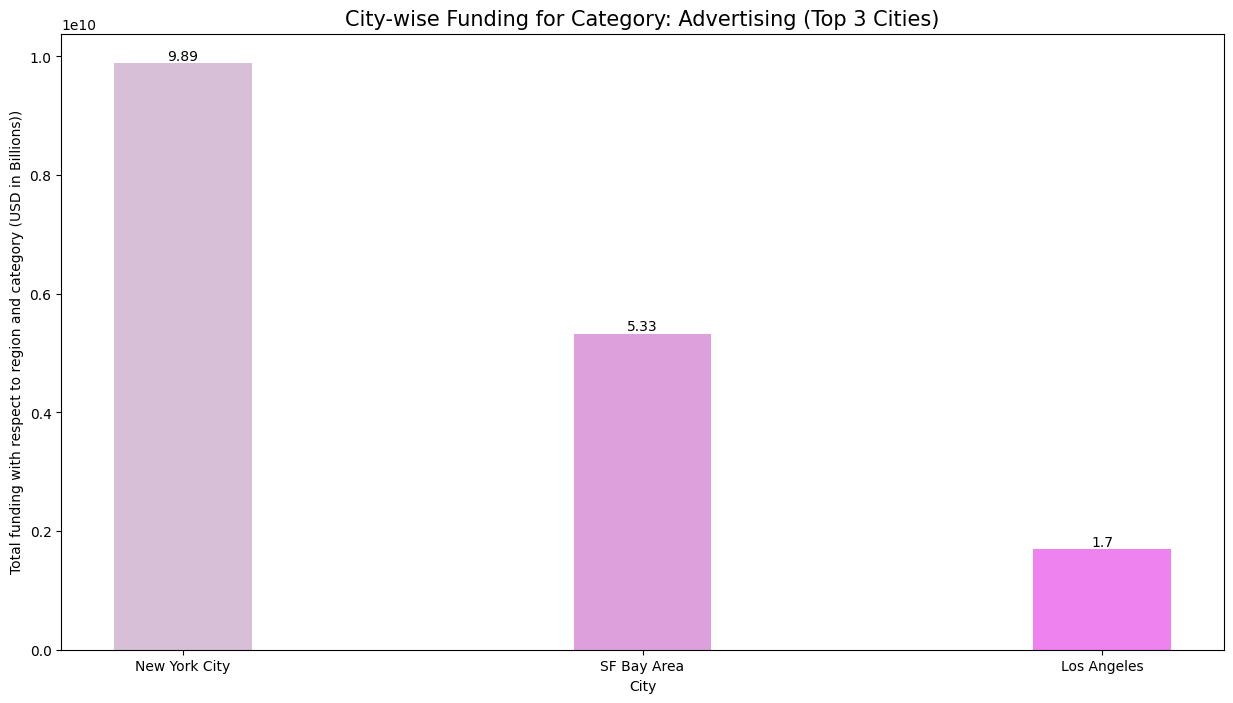

In [38]:
import matplotlib.pyplot as plt

# Assuming you have a 'city' column in your dataframe 'merged_df'
# You can replace 'city_column_name' with the actual column name in your dataframe

# Get the top 5 categories
top5_categories = funding_by_category_top5['category_list'].tolist()

# Filter the dataframe to include only the top 20 categories
top5_category_df = merged_df[merged_df['category_list'].isin(top5_categories)]

# Group by 'category_list' and 'city_column_name' to get the sum of funding by city
city_group = top5_category_df.groupby(['category_list', 'region'])['funding_total_usd'].sum().reset_index(name='funding_sum')

# Get the top 3 cities by funding sum for each category
top3_cities_by_category = city_group.groupby('category_list').apply(lambda x: x.nlargest(3, 'funding_sum')).reset_index(drop=True)

# Loop through each category and create a bar plot for its top 3 cities
for category in top5_categories:
    # Filter the top 3 cities for the current category
    top3_cities_category = top3_cities_by_category[top3_cities_by_category['category_list'] == category]
    
    # Get the city, funding_sum values
    city = top3_cities_category['region'].tolist()
    funding_sum = top3_cities_category['funding_sum'].tolist()
    
    # Create a bar plot with funding_sum as the height of the bars
    plt.figure(figsize=(15,8))
    bars=plt.bar(city, funding_sum, color=["thistle","plum","violet"],width=0.3)
    plt.xlabel('City')
    plt.ylabel('Total funding with respect to region and category (USD in Billions))')
    plt.title(f'City-wise Funding for Category: {category} (Top 3 Cities)', fontsize=15)
    plt.xticks(rotation=0)
    plt.grid(False)
    for i, bar in enumerate(bars):
      plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, round(funding_sum[i]/1000000000,2), ha='center', va='bottom')
    plt.show()




In [39]:
# Convert the "amount" column from object to float
# mdf2["funding_total_usd"] = mdf2["funding_total_usd"].replace('-', '0')

# Convert the "funds_raised" column from object to int
# mdf2["funding_total_usd"] = mdf2["funding_total_usd"].astype(int)
# mdf2["funding_total_usd"] = mdf2["funding_total_usd"].astype(float)

In [40]:
# from sklearn.preprocessing import MinMaxScaler
# Create a MinMaxScaler object
# scaler = MinMaxScaler()

# Specify the column to be normalized
#column_name = 'funding_total_usd'

# Fit and transform the specified column using Min-Max scaling
# mdf2["funding_total_usd"] = scaler.fit_transform(mdf2["funding_total_usd"].values.reshape(-1, 1))

# Display the normalized column
# print(mdf2)

## Data preparation for Questions 4,5,6,7

In [41]:
acquired_startups_df = merged_df[merged_df['status'] == "acquired"]
acquired_startups_df

,name,category_list,funding_total_usd,funding_rounds,status,country_code,state_names,region,city,founded_at,first_funding_at,last_funding_at,last_funding_at_year
25557,Clearwire,Internet,5.820000e+09,6,acquired,USA,Washington,Seattle,Kirkland,2003-10-01,2003-10-01,2013-02-27,2013
20461,MediaVast,Advertising,4.715000e+09,2,acquired,USA,New York,New York City,New York,1999-01-01,1999-01-01,2006-05-17,2006
6595,Fisker Automotive,Automotive,1.471000e+09,9,acquired,USA,California,Anaheim,Irvine,2008-01-01,2008-01-01,2012-04-02,2012
37200,Avito.ru,Advertising,1.342000e+09,5,acquired,RUS,Moskva,Moscow,Moscow,2008-01-01,2008-01-01,2015-10-23,2015
30544,Youku,Broadcasting,1.320000e+09,6,acquired,CHN,Shanghai,Shanghai,Shanghai,2006-12-21,2006-12-21,2014-04-28,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13434,SurfTech,Sports,0.000000e+00,1,acquired,USA,California,SF Bay Area,Santa Cruz,1989-01-01,1989-01-01,2007-09-20,2007
43444,INetU Managed Hosting,Content,0.000000e+00,1,acquired,USA,Pennsylvania,Allentown,Allentown,1996-12-01,1996-12-01,2013-01-08,2013
13373,SuccessFactors,Career Management,0.000000e+00,2,acquired,USA,California,SF Bay Area,South San Francisco,2001-05-01,2001-05-01,2007-11-20,2007
43481,Jibbigo,Apps,0.000000e+00,1,acquired,USA,Pennsylvania,Pittsburgh,Pittsburgh,2009-01-01,2009-01-01,2011-04-28,2011


In [42]:
# Convert "funding_total_usd" column to float
acquired_startups_df["funding_total_usd"] = acquired_startups_df["funding_total_usd"].astype(float)

# Round off "funding_total_usd" column to 3 decimal places using numpy
acquired_startups_df["funding_total_usd"] = np.round(acquired_startups_df["funding_total_usd"], 3)

# Display the updated dataframe information
acquired_startups_df.info()

# Display the first few rows of the updated dataframe
acquired_startups_df.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5181 entries, 25557 to 13477
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  5181 non-null   object 
 1   category_list         5181 non-null   object 
 2   funding_total_usd     5181 non-null   float64
 3   funding_rounds        5181 non-null   int64  
 4   status                5181 non-null   object 
 5   country_code          5181 non-null   object 
 6   state_names           5181 non-null   object 
 7   region                5181 non-null   object 
 8   city                  5181 non-null   object 
 9   founded_at            5181 non-null   object 
 10  first_funding_at      5181 non-null   object 
 11  last_funding_at       5181 non-null   object 
 12  last_funding_at_year  5181 non-null   int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 566.7+ KB


,name,category_list,funding_total_usd,funding_rounds,status,country_code,state_names,region,city,founded_at,first_funding_at,last_funding_at,last_funding_at_year
25557,Clearwire,Internet,5.820000e+09,6,acquired,USA,Washington,Seattle,Kirkland,2003-10-01,2003-10-01,2013-02-27,2013
20461,MediaVast,Advertising,4.715000e+09,2,acquired,USA,New York,New York City,New York,1999-01-01,1999-01-01,2006-05-17,2006
6595,Fisker Automotive,Automotive,1.471000e+09,9,acquired,USA,California,Anaheim,Irvine,2008-01-01,2008-01-01,2012-04-02,2012
37200,Avito.ru,Advertising,1.342000e+09,5,acquired,RUS,Moskva,Moscow,Moscow,2008-01-01,2008-01-01,2015-10-23,2015
30544,Youku,Broadcasting,1.320000e+09,6,acquired,CHN,Shanghai,Shanghai,Shanghai,2006-12-21,2006-12-21,2014-04-28,2014


In [43]:

def round_to_scientific_notation(x, decimals):
    return format(round(x, decimals), f".{decimals}e")

# Convert "funding_total_usd" column to float
acquired_startups_df["funding_total_usd"] = acquired_startups_df["funding_total_usd"].astype(float)

# Round off "funding_total_usd" column to 3 decimal places using the custom function
acquired_startups_df["funding_total_usd"] = acquired_startups_df["funding_total_usd"].apply(round_to_scientific_notation, decimals=3)

# Display the updated dataframe information
acquired_startups_df.info()

# Display the first few rows of the updated dataframe
acquired_startups_df.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5181 entries, 25557 to 13477
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   name                  5181 non-null   object
 1   category_list         5181 non-null   object
 2   funding_total_usd     5181 non-null   object
 3   funding_rounds        5181 non-null   int64 
 4   status                5181 non-null   object
 5   country_code          5181 non-null   object
 6   state_names           5181 non-null   object
 7   region                5181 non-null   object
 8   city                  5181 non-null   object
 9   founded_at            5181 non-null   object
 10  first_funding_at      5181 non-null   object
 11  last_funding_at       5181 non-null   object
 12  last_funding_at_year  5181 non-null   int64 
dtypes: int64(2), object(11)
memory usage: 566.7+ KB


,name,category_list,funding_total_usd,funding_rounds,status,country_code,state_names,region,city,founded_at,first_funding_at,last_funding_at,last_funding_at_year
25557,Clearwire,Internet,5.820e+09,6,acquired,USA,Washington,Seattle,Kirkland,2003-10-01,2003-10-01,2013-02-27,2013
20461,MediaVast,Advertising,4.715e+09,2,acquired,USA,New York,New York City,New York,1999-01-01,1999-01-01,2006-05-17,2006
6595,Fisker Automotive,Automotive,1.471e+09,9,acquired,USA,California,Anaheim,Irvine,2008-01-01,2008-01-01,2012-04-02,2012
37200,Avito.ru,Advertising,1.342e+09,5,acquired,RUS,Moskva,Moscow,Moscow,2008-01-01,2008-01-01,2015-10-23,2015
30544,Youku,Broadcasting,1.320e+09,6,acquired,CHN,Shanghai,Shanghai,Shanghai,2006-12-21,2006-12-21,2014-04-28,2014


In [44]:
aq = pd.read_csv('acquisitions.csv')
aq.head()

,company_permalink,company_name,company_category_list,company_country_code,company_state_code,company_region,company_city,acquirer_permalink,acquirer_name,acquirer_category_list,acquirer_country_code,acquirer_state_code,acquirer_region,acquirer_city,acquired_at,acquired_month,price_amount,price_currency_code
0,/organization/003-ru,003.RU,Consumer Electronics|Electronics|Internet,RUS,48,Moscow,Moscow,/organization/media-saturn,Media Saturn,Enterprise Software|Media|Sales and Marketing,ESP,56,Barcelona,Barcelona,2012-07-23,2012-07,NaN,USD
1,/organization/0958572-b-c-ltd,0958572 B.C. Ltd.,NaN,NaN,NaN,NaN,NaN,/organization/atlas-intellectual-property-mana...,ATLAS Intellectual Property Management Co.,Finance|FinTech|Mobile|Telecommunications,USA,WA,Seattle,Seattle,2012-02-02,2012-02,9000000.0,USD
2,/organization/1-800-communications,1-800 Communications,NaN,USA,NY,Long Island,Hicksville,/organization/carsdirect-com,CarsDirect.com,E-Commerce,USA,CA,Los Angeles,El Segundo,2005-06-12,2005-06,NaN,USD
3,/organization/1-800-contacts,1-800 Contacts,Consumer Goods|Retail,USA,UT,Salt Lake City,Draper,/organization/thomas-h-lee-partners,Thomas H. Lee Partners,Business Development|Impact Investing|Investme...,USA,MA,Boston,Boston,2014-01-07,2014-01,NaN,USD
4,/organization/1-844-446-4460-pogo-customer-ser...,Games Support +1-800-311-5934 Pogo Games techn...,NaN,NaN,NaN,NaN,NaN,/organization/pogo-customer-service-number-1-8...,Games Support +1-800-311-5934 Pogo Games techn...,NaN,USA,NY,New York City,Mamaroneck,2001-02-02,2001-02,NaN,USD


In [45]:
aq['acquired_at_year'] = aq['acquired_at'].str.split('-').str[0]
aq["acquired_at_year"].unique()

array(['2012', '2005', '2014', '2001', '2015', '2006', '2013', '2011',
       '2009', '2008', '1999', '2002', '2010', '2007', '2000', '2004',
       '1997', '1991', '2003', '1995', '1998', '1994', nan, '1989',
       '1993', '1996', '1972', '1992', '1990', '3201', '1977', '1981',
       '2016', '1988', '1984', '1980', '1987', '1966', '1973', '1982',
       '1201', '1978', '1960', '1986', '1967'], dtype=object)

In [46]:
aq.dropna(subset=['acquired_at_year'], inplace=True)
aq.isnull().sum()

company_permalink             0
company_name                  0
company_category_list      4979
company_country_code       4664
company_state_code         4944
company_region             4906
company_city               4906
acquirer_permalink            0
acquirer_name                 0
acquirer_category_list     2387
acquirer_country_code      1168
acquirer_state_code        1432
acquirer_region            1356
acquirer_city              1356
acquired_at                   0
acquired_month                2
price_amount              13946
price_currency_code           4
acquired_at_year              0
dtype: int64

In [47]:
aq["acquired_at_year"] = aq["acquired_at_year"].astype(int)
aq = aq[aq["acquired_at_year"] <= 2023]

In [48]:
aq = aq[aq["acquired_at_year"] != 1201]

In [49]:
# Dropping the permalink and url cz they are not being used and we tried web scrapping to
aq1 = aq[['company_name', 'acquired_at_year','acquirer_name']]

# In name columns some names doesn't make sense cz of special characters so we are treating them
aq1['company_name'] = aq1['company_name'].replace({'[^A-Za-z0-9\s\-\.\,]+': ' '}, regex=True)

In [50]:
aq1 = aq1.rename(columns={'company_name': 'name'})

In [51]:
comp_aq = pd.merge(acquired_startups_df, aq1, on='name', how='inner')

In [52]:
comp_aq['founded_at_year'] = comp_aq['founded_at'].str.split('-').str[0]
comp_aq['acquired_at_year'] = comp_aq['acquired_at_year'].astype(int)
comp_aq['founded_at_year'] = comp_aq['founded_at_year'].astype(int)
comp_aq['funding_year_difference'] = comp_aq['acquired_at_year'] - comp_aq['founded_at_year']

In [53]:
comp_aq["funding_year_difference"].unique()

array([  9,   8,   6,   7,   4,  86,  30,   3,   1,  16,  46,  -9,  -6,
        10,  53,  11,  18,  14,  33,  12,  15,  17,   5,  13,  21,  19,
        20, 115,  27,   2,  22,  28,  31,  24,  68, -20,  23,  37,  80,
       -10,  32,   0,  35,  40,  -4,  34,  26,  25,  -1, 146,  83,  29,
        -2,  54, 171,  38, 118,  -7,  -3,  61, 109,  98,  -8,  -5,  71,
       -12,  42,  41,  36, 103,  43,  51, -11,  55,  47,  57,  66,  76,
        81,  49])

In [54]:
comp_aq = comp_aq[comp_aq["funding_year_difference"] > 0]


In [55]:
inv=pd.read_csv("investments.csv")
inv.shape
inv.columns

Index(['company_permalink', 'company_name', 'company_category_list',
       'company_country_code', 'company_state_code', 'company_region',
       'company_city', 'investor_permalink', 'investor_name',
       'investor_country_code', 'investor_state_code', 'investor_region',
       'investor_city', 'funding_round_permalink', 'funding_round_type',
       'funding_round_code', 'funded_at', 'raised_amount_usd'],
      dtype='object')

In [56]:
inv1 = inv[[ 'company_name', 'company_category_list',
       'company_country_code', 'company_state_code', 'company_region',
       'company_city', 'investor_name',
       'investor_country_code', 'investor_region', 'funding_round_type',
       'funding_round_code', 'funded_at', 'raised_amount_usd']]

In [57]:
inv1 = inv.dropna(subset=['company_country_code', 'company_state_code', 'company_region','company_city'])

In [58]:
inv1.isna().mean().round(4)*100

company_permalink           0.00
company_name                0.00
company_category_list       1.11
company_country_code        0.00
company_state_code          0.00
company_region              0.00
company_city                0.00
investor_permalink          0.01
investor_name               0.01
investor_country_code      17.99
investor_state_code        25.78
investor_region            25.24
investor_city              18.65
funding_round_permalink     0.00
funding_round_type          0.00
funding_round_code         50.75
funded_at                   0.00
raised_amount_usd          11.59
dtype: float64

In [59]:
#nul = inv1['investor_name'].isna()
#inv1.loc[nul,:]
inv1 = inv1.loc[inv1['investor_name'].notna()]

In [60]:
inv1.isna().mean().round(4)*100

company_permalink           0.00
company_name                0.00
company_category_list       1.11
company_country_code        0.00
company_state_code          0.00
company_region              0.00
company_city                0.00
investor_permalink          0.00
investor_name               0.00
investor_country_code      17.99
investor_state_code        25.78
investor_region            25.23
investor_city              18.64
funding_round_permalink     0.00
funding_round_type          0.00
funding_round_code         50.75
funded_at                   0.00
raised_amount_usd          11.59
dtype: float64

In [61]:
gp_region = inv1.groupby('investor_name')['company_region'].apply(lambda x: x.value_counts().idxmax())
inv1['investor_region'] = inv1['investor_region'].fillna(inv1['investor_name'].map(gp_region))

In [62]:
gp_country = inv1.groupby('investor_name')['company_country_code'].apply(lambda x: x.value_counts().idxmax())
inv1['investor_country_code'] = inv1['investor_country_code'].fillna(inv1['investor_name'].map(gp_country))

In [63]:
inv1.isna().mean().round(4)*100

company_permalink           0.00
company_name                0.00
company_category_list       1.11
company_country_code        0.00
company_state_code          0.00
company_region              0.00
company_city                0.00
investor_permalink          0.00
investor_name               0.00
investor_country_code       0.00
investor_state_code        25.78
investor_region             0.00
investor_city              18.64
funding_round_permalink     0.00
funding_round_type          0.00
funding_round_code         50.75
funded_at                   0.00
raised_amount_usd          11.59
dtype: float64

In [64]:
pdf1 = inv1[['company_region','investor_name','investor_region','funding_round_type','raised_amount_usd']]

In [65]:
pdf1.isnull().sum()

company_region            0
investor_name             0
investor_region           0
funding_round_type        0
raised_amount_usd     15201
dtype: int64

In [66]:
# In name columns some names doesn't make sense cz of special characters so we are treating them
pdf1['investor_name'] = pdf1['investor_name'].replace({'[^A-Za-z\s\-\.\,]+': ' '}, regex=True)
pdf1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131162 entries, 0 to 143014
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   company_region      131162 non-null  object 
 1   investor_name       131162 non-null  object 
 2   investor_region     131162 non-null  object 
 3   funding_round_type  131162 non-null  object 
 4   raised_amount_usd   115961 non-null  float64
dtypes: float64(1), object(4)
memory usage: 6.0+ MB


In [67]:
pdf1['investor_name'].unique()

array(['DT Capital Partners', 'VCDE Venture Partners', 'Capital One', ...,
       'Paul Reining', 'Crescent Point Energy', 'Daily Mail'],
      dtype=object)

## Question 4 : Investment companies that can redirect funds into the startup economy.

In [68]:
  # Set plot size

# Groupby investor_name and sum the raised_amount_usd
grouped = pdf1.groupby('investor_name')['raised_amount_usd'].sum().reset_index(name='total_invested_amount')

# Sort by total_invested_amount in descending order
grouped = grouped.sort_values(by='total_invested_amount', ascending=False)

# Select top 20 records
top20 = grouped.head(20)
top20['investor_name'] = top20['investor_name'].astype(str)
top20 = top20.merge(pdf1[['investor_name', 'investor_region']], on='investor_name', how='left')

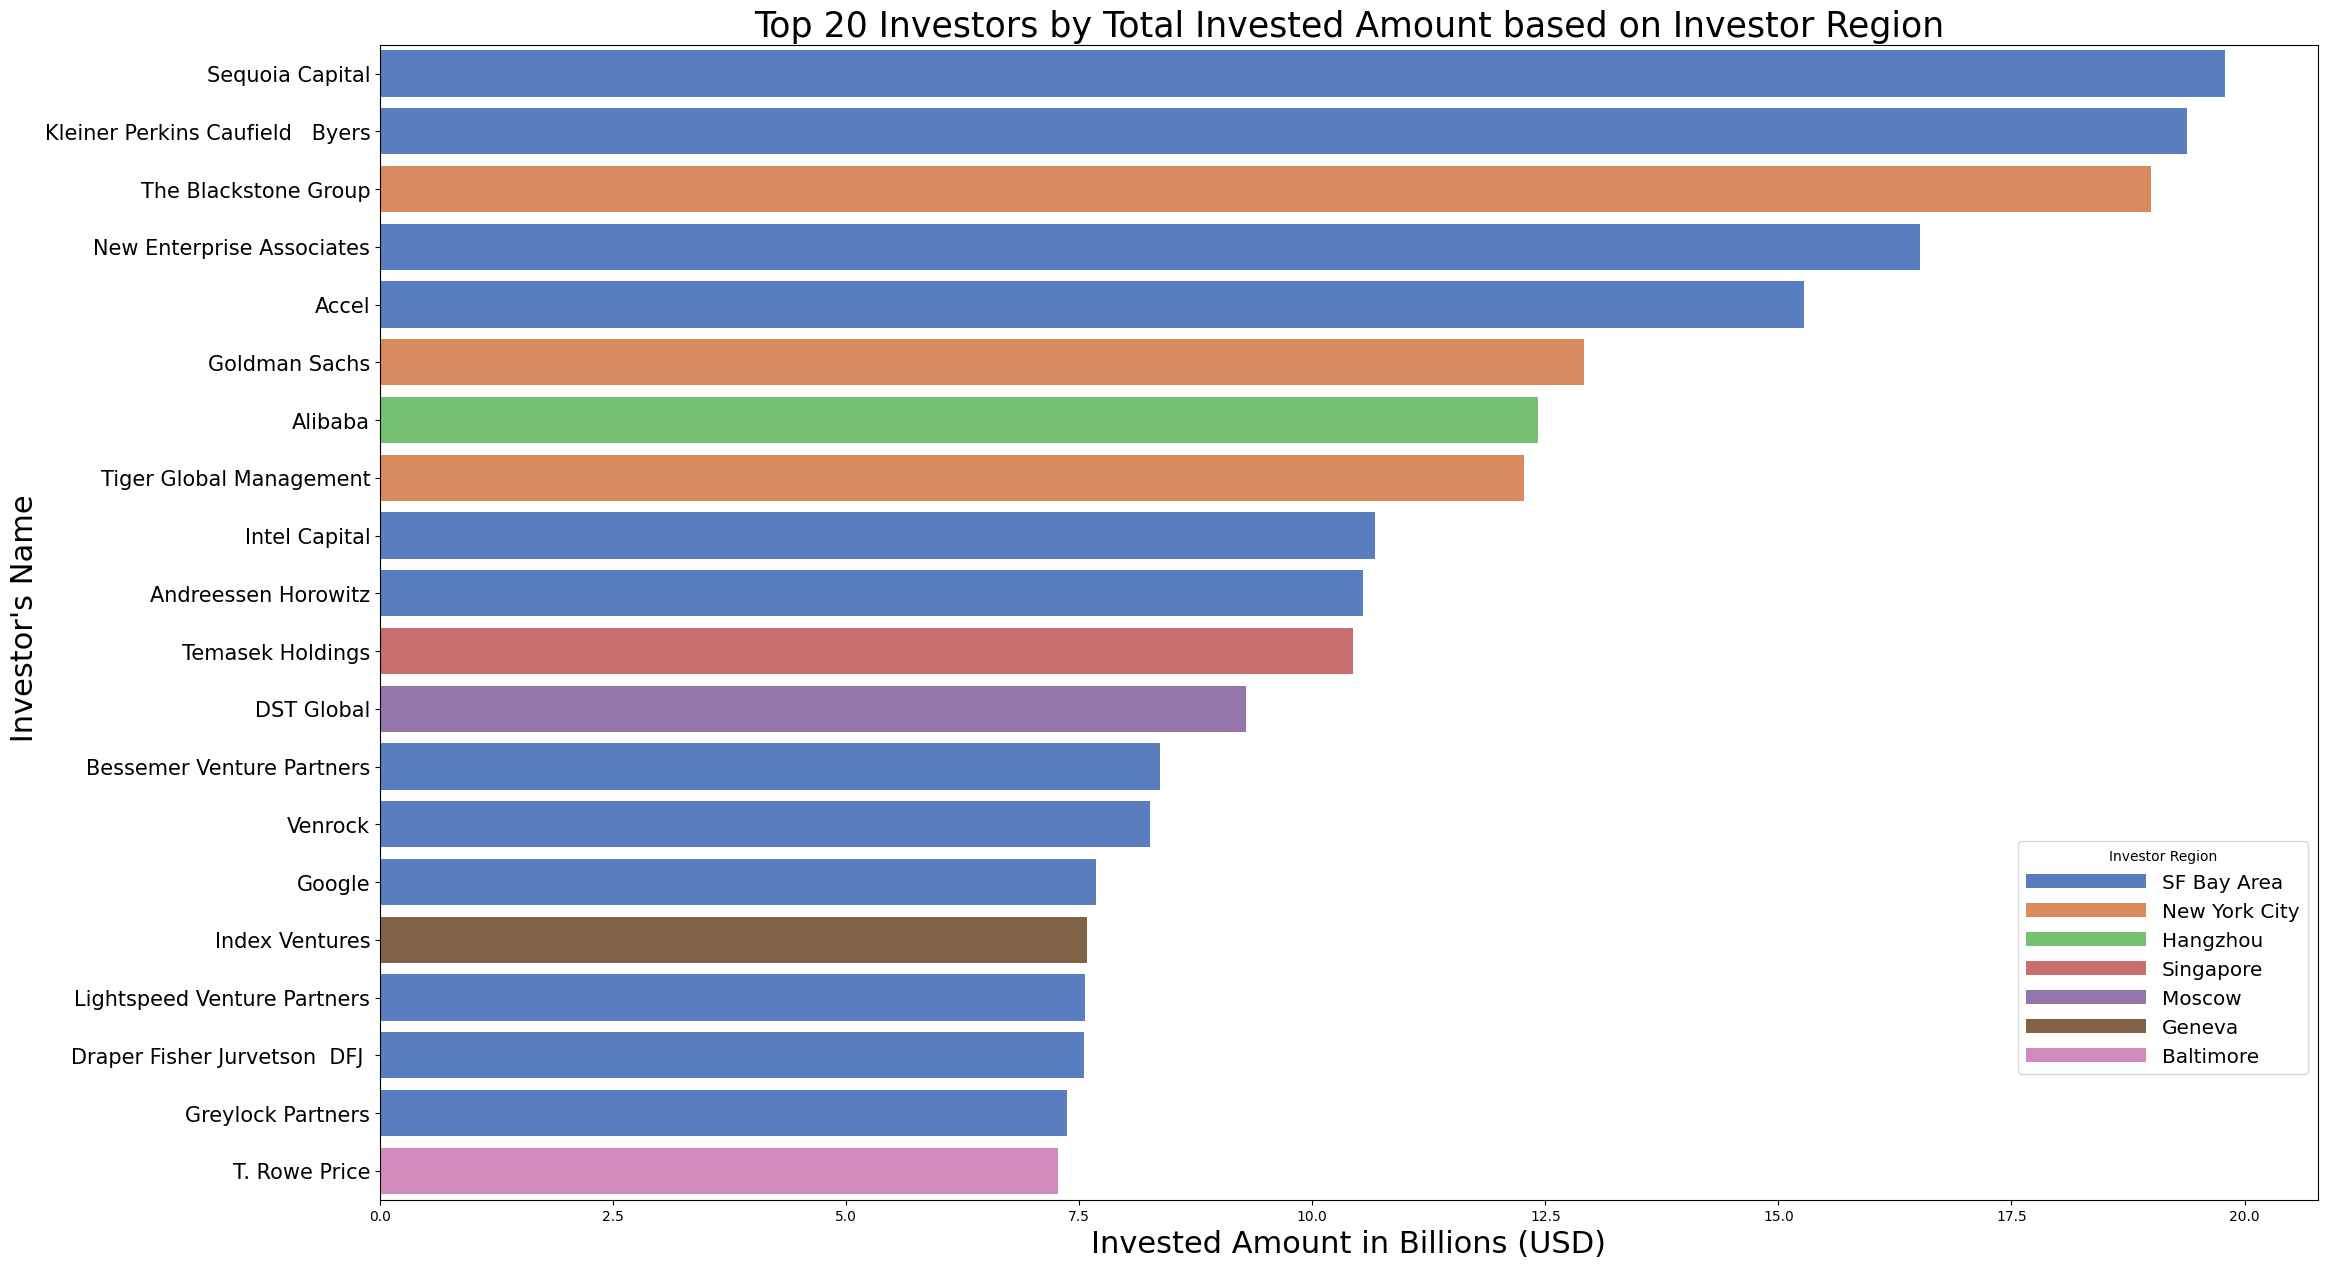

In [69]:
from matplotlib.patches import Rectangle
plt.figure(figsize=(25,15))
# Use the `hue` parameter to specify the column to use for filling the bars
sns.barplot(x=top20['total_invested_amount']/1000000000, y='investor_name', hue='investor_region', data=top20,orient='h', palette='muted', dodge=False)

# Set plot labels and title
plt.ylabel(" Investor's Name",fontsize=22)
plt.xlabel('Invested Amount in Billions (USD)',fontsize=22)
plt.title('Top 20 Investors by Total Invested Amount based on Investor Region',fontsize=25)

# Rotate x-axis labels
plt.yticks(fontsize=15)

# Get current handles and labels
# handles, labels = plt.gca().get_legend_handles_labels()
# patches=plt.gca().patches

# handles = [Rectangle((0,0),1,1,color=patch.get_facecolor()) for patch in patches]
# Add spaces to labels to increase legend width
#labels = [label + ' ' * 10 for label in labels]

handles, labels = plt.gca().get_legend_handles_labels()
# Show legend
plt.legend(handles=handles[:len(labels)], labels=labels, title='Investor Region', bbox_to_anchor=(1, 0.1), loc="lower right", handlelength=6, fontsize='x-large')

plt.grid(False)
# Show the plot
plt.show()


## Question 5: Amount raised through different funding rounds like venture capital, seed investment etc.


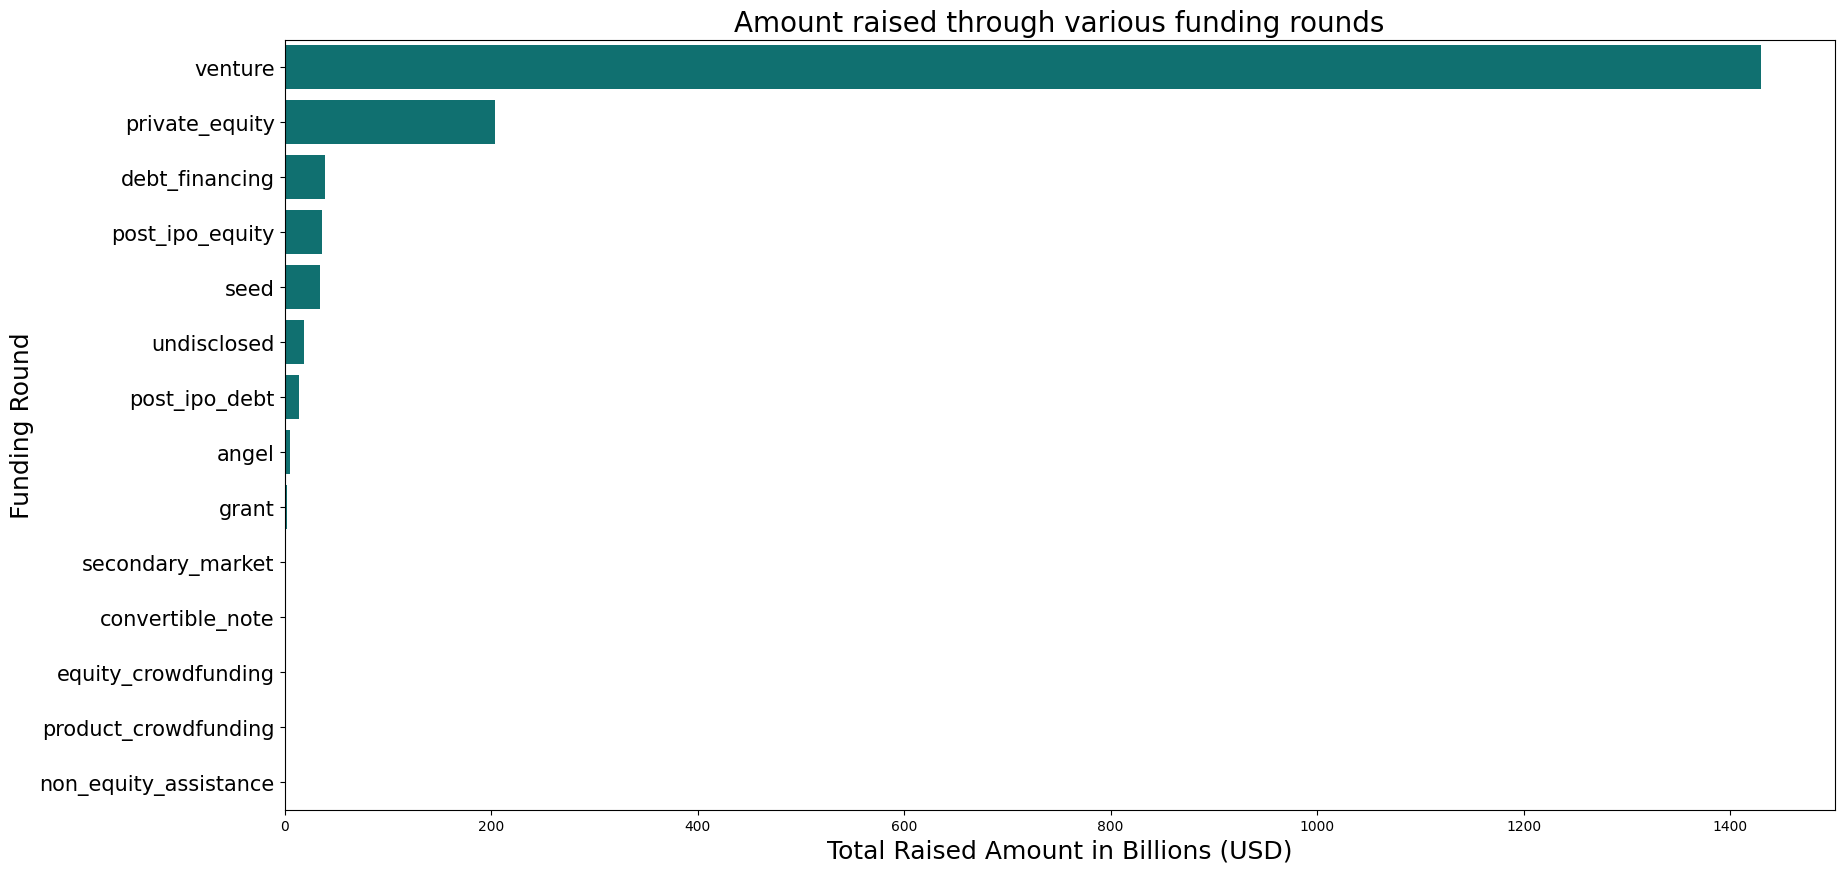

In [70]:

# Raised column with nulls
# Group by investor name and sum the invested amount
grouped = pdf1.groupby('funding_round_type')['raised_amount_usd'].sum().reset_index(name='total_invested_amount')

# Sort by total_invested_amount in descending order
grouped = grouped.sort_values(by='total_invested_amount', ascending=False)

round_fund = grouped.head(20)
round_fund['funding_round_type'] = round_fund['funding_round_type'].astype(str)
# Plot the top 20 records
plt.figure(figsize=(20, 10))
sns.barplot(x=round_fund['total_invested_amount']/1000000000,y=round_fund['funding_round_type'],color="teal")
plt.ylabel('Funding Round',fontsize=18)
plt.xlabel('Total Raised Amount in Billions (USD)',fontsize=18)
plt.title('Amount raised through various funding rounds',fontsize=20)
plt.yticks(fontsize=15)
plt.show()


In [71]:

# ### Imputing nulls of raised funds column with mean and then plotting the graph

# # Calculate the mean of non-null values in 'raised_funds_usd' column
# mean_raised_funds = pdf1['raised_amount_usd'].mean()

# # Replace null values with the calculated mean
# pdf1['raised_amount_usd'].fillna(mean_raised_funds, inplace=True)

# # Group by investor name and sum the invested amount
# grouped = pdf1.groupby('funding_round_type')['raised_amount_usd'].sum().reset_index(name='total_invested_amount')

# # Sort by total_invested_amount in descending order
# grouped = grouped.sort_values(by='total_invested_amount', ascending=False)

# # Select top 20 records
# round_fund = grouped.head(20)
# round_fund['funding_round_type'] = round_fund['funding_round_type'].astype(str)
# # Plot the top 20 records
# plt.figure(figsize=(20, 10))
# sns.barplot(x=round_fund['total_invested_amount'],y=round_fund['funding_round_type'],color="teal")
# plt.ylabel('Name of the funding Round',fontsize=15)
# plt.xlabel('Total Raised Amount in Millions (USD)',fontsize=15)
# plt.title('Amount raised through various funding rounds',fontsize=20)
# plt.yticks(fontsize=15)
# plt.show()


In [72]:
# # Group by investor name and sum the invested amount
# grouped = pdf1.groupby('investor_name')['raised_amount_usd'].sum().reset_index(name='total_invested_amount')

# # Sort by total_invested_amount in descending order
# grouped = grouped.sort_values(by='total_invested_amount', ascending=False)

# # Select top 20 records
# top20 = grouped.head(20)
# top20['investor_name'] = top20['investor_name'].astype(str)
# # Plot the top 20 records
# plt.figure(figsize=(12, 8))
# sns.barplot(x=top20['total_invested_amount'], y=top20['investor_name'],color="lightcoral")
# plt.ylabel('Name of the Investor',fontsize=15)
# plt.xlabel('Total Invested Amount in Millions (USD)',fontsize=15)
# plt.title('Top 20 Investors by Total Invested Amount',fontsize=25)
# plt.yticks(fontsize=15)
# plt.show()

## Question 6: Significant acquisitions made by a company created by an acquirer.

In [73]:

comp_aq['funding_total_usd'].unique()

# Sort the 'Age' column in ascending order
comp_aq.sort_values('funding_total_usd', inplace=True,ascending=False)

comp_aq["funding_total_usd"] = comp_aq["funding_total_usd"].astype(float)
comp_aq["funding_total_usd"] = comp_aq["funding_total_usd"].round(3)



comp_aq1 = comp_aq[['name','acquirer_name','acquired_at_year','funding_total_usd']]
comp_aq1['funding_total_usd']=(comp_aq1['funding_total_usd']/1e9).round(2)
comp_aq1 = comp_aq1.sort_values('funding_total_usd', ascending=False)
comp_aq1.head(20)

,name,acquirer_name,acquired_at_year,funding_total_usd
0,Clearwire,Sprint Nextel,2012,5.82
1,MediaVast,Getty Images,2007,4.72
2,Fisker Automotive,Wanxiang America,2014,1.47
3,Avito.ru,Naspers,2015,1.34
4,Terra-Gen Power,NRG Yield,2014,1.20
5,SunEdison,MEMC Electronic Materials,2009,1.04
7,AOL,Verizon Communications,2015,1.00
6,Motorola Solutions,Zebra Technologies,2014,1.00
8,Kuaidi Dache,Didi Kuaidi,2015,0.95
9,Better Place,Sunrise Group,2013,0.92


## Question 7: How long does a startup take to be acquired

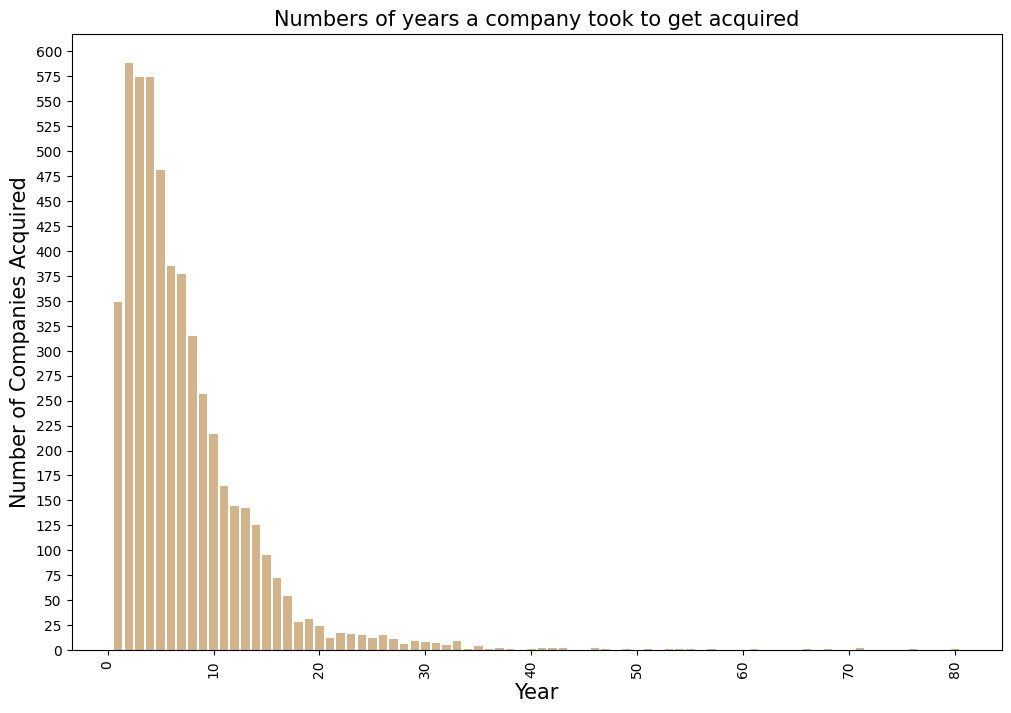

In [74]:

acquisitions_by_year = comp_aq.groupby('funding_year_difference').size().reset_index(name='count')
acquisitions_by_year = acquisitions_by_year[acquisitions_by_year["funding_year_difference"] <= 80]
# Plot the data as a bar graph
plt.figure(figsize=(12, 8))
plt.bar(acquisitions_by_year['funding_year_difference'], acquisitions_by_year['count'],color="tan")
plt.xlabel('Year',fontsize=15)
plt.xticks(np.arange(0, acquisitions_by_year['funding_year_difference'].max()+10, 10))
plt.ylabel('Number of Companies Acquired',fontsize=15)
plt.yticks(np.arange(0, acquisitions_by_year['count'].max()+25, 25))
plt.title('Numbers of years a company took to get acquired',fontsize=15)
plt.grid(False)
plt.xticks(rotation=90)
plt.show()

In [75]:
merged_df

,name,category_list,funding_total_usd,funding_rounds,status,country_code,state_names,region,city,founded_at,first_funding_at,last_funding_at,last_funding_at_year
22100,Verizon Communications,Communications Infrastructure,3.007950e+10,5,ipo,USA,New York,New York City,New York,1983-10-07,1983-10-07,2014-02-28,2014
33397,Freescale Semiconductor,Semiconductors,1.760000e+10,1,ipo,USA,Texas,Austin,Austin,1953-01-01,1953-01-01,2006-10-21,2006
14321,Uber,Automotive,8.207450e+09,13,operating,USA,California,SF Bay Area,San Francisco,2009-03-01,2009-03-01,2015-09-07,2015
25557,Clearwire,Internet,5.820000e+09,6,acquired,USA,Washington,Seattle,Kirkland,2003-10-01,2003-10-01,2013-02-27,2013
37423,Sberbank,Banking,5.800000e+09,1,ipo,RUS,Moskva,Moscow,Moscow,2014-07-07,2014-07-07,2014-07-07,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13473,Swift Endeavor,Entertainment,0.000000e+00,1,operating,USA,California,Los Angeles,Beverly Hills,2014-03-24,2014-03-24,2014-09-14,2014
43416,HighPoint Solutions,Services,0.000000e+00,1,operating,USA,Pennsylvania,Philadelphia,Philadelphia,2013-03-15,2013-03-15,2013-03-15,2013
13455,SVR Tracking,Other,0.000000e+00,1,operating,USA,California,San Diego,San Diego,2015-08-17,2015-08-17,2015-08-17,2015
43418,HMP Communications,Other,0.000000e+00,1,operating,USA,Pennsylvania,Philadelphia,Malvern,2008-04-29,2008-04-29,2008-04-29,2008


# Model Building

In [77]:
mdf3 = merged_df

mdf3.drop(columns=['name', 'state_names'
                  ,'city', 'funding_rounds', 'founded_at', 'first_funding_at',
                  'last_funding_at'],axis=1,inplace=True)

mdf3["funding_total_usd"] = mdf3["funding_total_usd"].replace('0', '-')

mdf3['funding_total_usd'] = pd.to_numeric(mdf3['funding_total_usd'], errors='coerce')
# group by category_list and country_code, and impute missing values using the median value for each group
mdf3['funding_total_usd'] = mdf3.groupby(['category_list', 'country_code'])['funding_total_usd'].transform(lambda x: x.fillna(x.mean()))

# There are nulls after above treatment there are no zeros in the data hence allocating them for the nulls
mdf3['funding_total_usd'].fillna(0,inplace=True)

# Now you can see the four unique data's in status column
# objects cannot be passed into a model
mdf3['status'].value_counts()

# As our target is status we are convertin them into numericals by mapping them
status_map = {'operating':1,'acquired':1,'closed':0,'ipo':1}
mdf3['status'] = mdf3['status'].map(status_map)
mdf3['status'].value_counts()

1    53223
0     4454
Name: status, dtype: int64

In [78]:
from sklearn.model_selection import train_test_split
X = mdf3.drop(columns=['status'],axis=1)
y = mdf3['status']

category = X.select_dtypes(include=['object'])

category_dummies = pd.get_dummies(category,drop_first=True)
# Now dropping the main columns as we no longer require them and concatinating the dummies with the main df
df_model = X.drop(list(category.columns),axis=1)
X = pd.concat([df_model,category_dummies],axis=1)

X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,test_size=0.2,random_state=100)

## Random Forest with Hyper Parameter Tuning

In [79]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report,roc_curve

X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,test_size=0.2,random_state=100)

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10, 25, 50, 100]
}

grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 3,
                           n_jobs=-1, verbose=1, scoring="roc_auc")

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


In [80]:
# Evaluate the model using accuracy, AUC, and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred, multi_class='ovo'))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.926490984743412
AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       848
           1       0.93      1.00      0.96     10688

    accuracy                           0.93     11536
   macro avg       0.46      0.50      0.48     11536
weighted avg       0.86      0.93      0.89     11536



## Random Forest (With Hyper Parameter Tuning and Resampling Techniques)

In [81]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)

X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,test_size=0.3,random_state=100)

X_res, y_res = sm.fit_resample(X_train, y_train)

# Train a Random Forest classifier on the resampled data
clf = RandomForestClassifier(**grid_search.best_params_)
clf.fit(X_res, y_res)

# Make predictions on the testing data
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)

print("Test - Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Test - Accuracy: 0.7980235783633842
Classification Report:
              precision    recall  f1-score   support

           0       0.16      0.39      0.22      1289
           1       0.94      0.83      0.88     16015

    accuracy                           0.80     17304
   macro avg       0.55      0.61      0.55     17304
weighted avg       0.89      0.80      0.83     17304



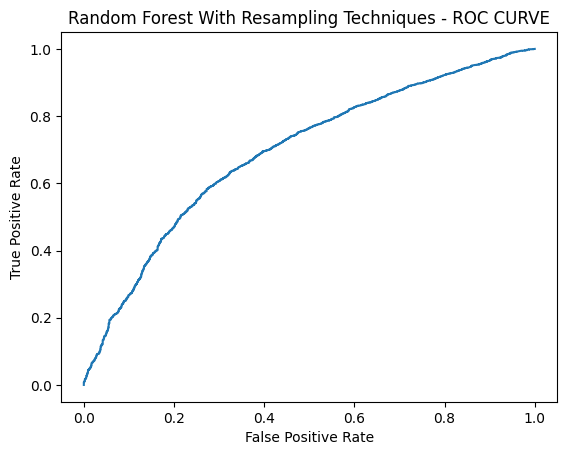

In [85]:
from sklearn.metrics import roc_curve
from sklearn import metrics

y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Random Forest With Resampling Techniques - ROC CURVE')
plt.show()

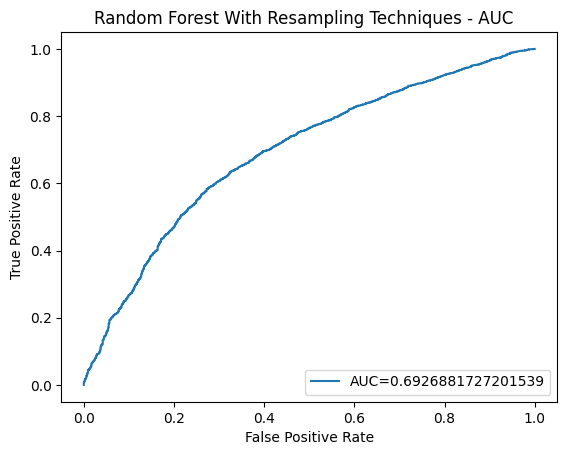

In [86]:
#define metrics
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Random Forest With Resampling Techniques - AUC  ')
plt.legend(loc=4)
plt.show()

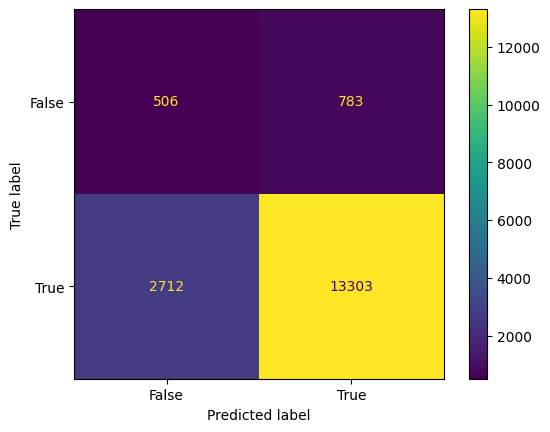

In [84]:
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# print('Confusion matrix of Random Forest with Resampling :\n', conf_matrix)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True]) 
cm_display.plot() 
plt.show()

## Categorical Boosting with Under sampling

In [87]:
import pandas as pd
from catboost import CatBoostClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply undersampling to the training set
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Train catboost model
cat_model = CatBoostClassifier(iterations=1000, learning_rate=0.1, random_seed=42)
cat_model.fit(X_train_resampled, y_train_resampled, verbose=False)

# Evaluate the model using accuracy, AUC, and classification report

y_prob = cat_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_prob)
print('AUC score:', auc_score)

# Calculate accuracy score
y_pred = cat_model.predict(X_test)
acc_score = accuracy_score(y_test, y_pred)
print('Accuracy score:', acc_score)


print("Classification Report:")
print(classification_report(y_test, y_pred))

AUC score: 0.7517530832310971
Accuracy score: 0.6774445214979196
Classification Report:
              precision    recall  f1-score   support

           0       0.16      0.71      0.26       911
           1       0.96      0.67      0.79     10625

    accuracy                           0.68     11536
   macro avg       0.56      0.69      0.53     11536
weighted avg       0.90      0.68      0.75     11536



## Categorical Boosting With Over Sampling

In [88]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply oversampling to the training set
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Train catboost model
cat_model = CatBoostClassifier(iterations=1000, learning_rate=0.1, random_seed=42)
cat_model.fit(X_train_resampled, y_train_resampled, verbose=False)

# Evaluate the model using accuracy, AUC, and classification report

y_prob = cat_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_prob)
print('AUC score:', auc_score)

# Calculate accuracy score
y_pred = cat_model.predict(X_test)
acc_score = accuracy_score(y_test, y_pred)
print('Accuracy score:', acc_score)


print("Classification Report:")
print(classification_report(y_test, y_pred))

AUC score: 0.7554038871311423
Accuracy score: 0.7632628294036061
Classification Report:
              precision    recall  f1-score   support

           0       0.19      0.59      0.28       911
           1       0.96      0.78      0.86     10625

    accuracy                           0.76     11536
   macro avg       0.57      0.69      0.57     11536
weighted avg       0.90      0.76      0.81     11536



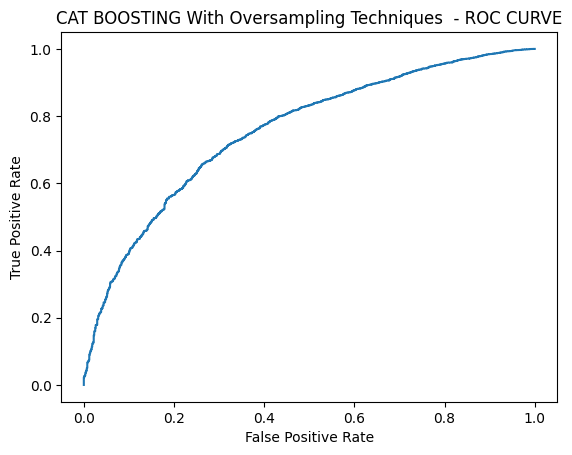

In [89]:
y_pred_proba = cat_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('CAT BOOSTING With Oversampling Techniques  - ROC CURVE')
plt.show()

AUC score: 0.7554038871311423


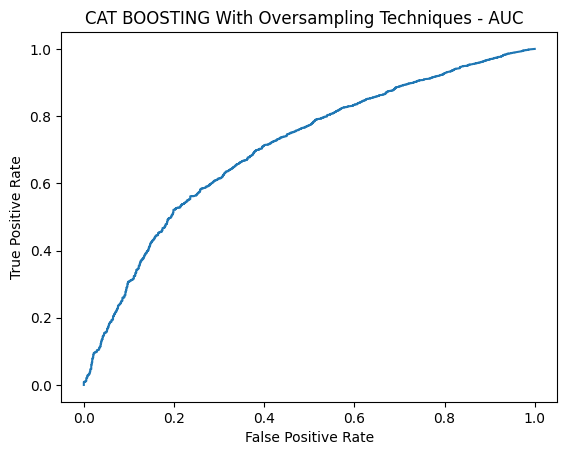

In [90]:
#define metrics
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
y_prob = cat_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_prob)
print('AUC score:', auc_score)
#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('CAT BOOSTING With Oversampling Techniques - AUC  ')
plt.show()

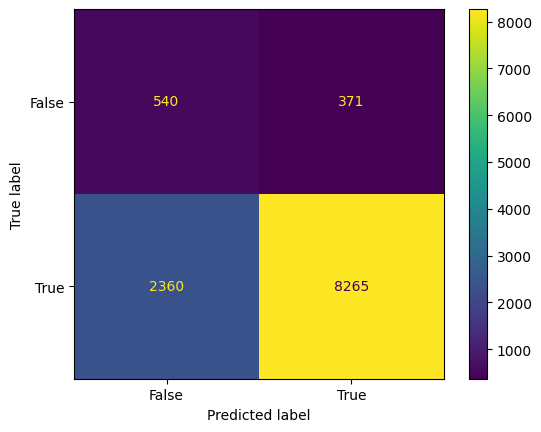

In [91]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# print('Confusion matrix of Cat Boost Over Sampling :\n', conf_matrix)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True]) 
cm_display.plot() 
plt.show()